Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.deconfounder_tree_legacy import DeconfounderTreeLegacy
from deconfounder.deconfounder_tree import DeconfounderTree
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
import random

In [2]:
# Load data
# df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
# df = df.sample(frac=1, random_state=42)

random.seed(42)
filename = "../data/criteo-uplift-v2.1.csv"
frac = 0.1
df = pd.read_csv(filename, skiprows=lambda i: i>0 and random.random() > frac)   #randomly skip some rows to avoid memory issues
order = list(range(len(df)))
random.shuffle(order)   
df = df.iloc[order]

Test the treatment was randomly assigned (according to the F-statistic, it appears it was not).

In [3]:
import statsmodels.api as sm

all_features = df.columns.values[:12].tolist()
X = sm.add_constant(df[all_features])
y = df.treatment
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     38.39
Date:                Thu, 11 May 2023   Prob (F-statistic):           5.14e-91
Time:                        01:30:06   Log-Likelihood:            -5.4271e+05
No. Observations:             1400005   AIC:                         1.085e+06
Df Residuals:                 1399992   BIC:                         1.086e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1066      0.075     14.831      0.0

We will use an experimental size of 50,000: it has a significance level of 0.1%.

In [4]:
exp_size = 50000
treated_ratio = 0.85 # same as in data
means = df.groupby('treatment').visit.mean()
variances = df.groupby('treatment').visit.var()
standard_error = np.sqrt(variances[1]/(exp_size*treated_ratio) + variances[0]/(exp_size*(1-treated_ratio)))
avg_effect = (means[1] - means[0])
p_value = (st.norm.cdf(-avg_effect/standard_error))*2
print(f"Average effect (entire sample): {round(avg_effect*100, 2)}%")
print(f"Standard error with sample size of {exp_size:,}: {round(standard_error*100, 2)}%")
print(f"p-value: {round(p_value, 4)}")

Average effect (entire sample): 1.04%
Standard error with sample size of 50,000: 0.24%
p-value: 0.0


Obtain experimental data.

In [5]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

exp_df = df[0:exp_size]
print_outcomes(exp_df)

Avg. Outcome (treated): 4.94%
Avg. Outcome (control): 3.68%
Estimated avg. effect: 1.26%


Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [6]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [7]:
train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
obs_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = obs_df[keep]
print(f"Size of observational data: {obs_df.shape[0]:,}")
print_outcomes(obs_df)

Size of observational data: 630,831
Avg. Outcome (treated): 5.3%
Avg. Outcome (control): 1.26%
Estimated avg. effect: 4.03%


Obtain evaluation data

In [8]:
eval_df = df[train_size:].copy()

Evaluate ad-hoc policy used to generate confounding (interesting: actually good for treatment assignment).

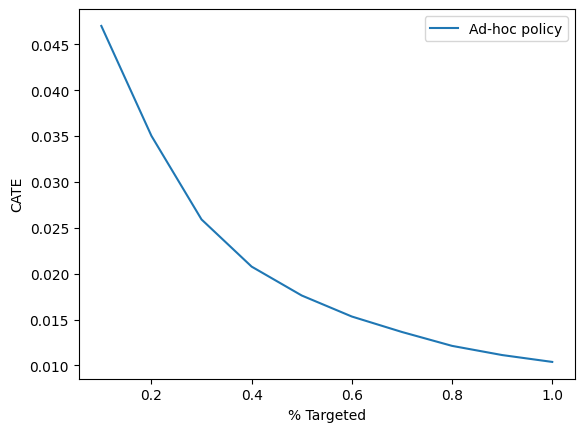

In [9]:
def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    size = 10
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        effect = avg_outcomes.loc[1] - avg_outcomes.loc[0]
        fractions.append(fraction)
        effects.append(effect)
    plt.plot(fractions, effects, label=title)
    plt.xlabel("% Targeted")
    plt.ylabel("CATE")
    plt.legend()

eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
plt.show()

Train policy with experimental data.

In [10]:
def fit_causal_tree(df_causal, min_samples_leaf=5000, tune=False):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        tuned_parameters = [{'min_samples_leaf': range(1000, 10000, 1000)}]
        grid_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        causal_tree = grid_tree.best_estimator_
    else:
        causal_tree = CausalTree(min_samples_leaf=min_samples_leaf, random_state=42)
        causal_tree.fit(X, y)   
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return causal_tree

exp_tree = fit_causal_tree(exp_df, tune=True)

Best parameters set found on development set:
{'min_samples_leaf': 5000}
--- Time to fit (and tune) causal tree 2.777495861053467 seconds ---


Evaluate model with experimental data.

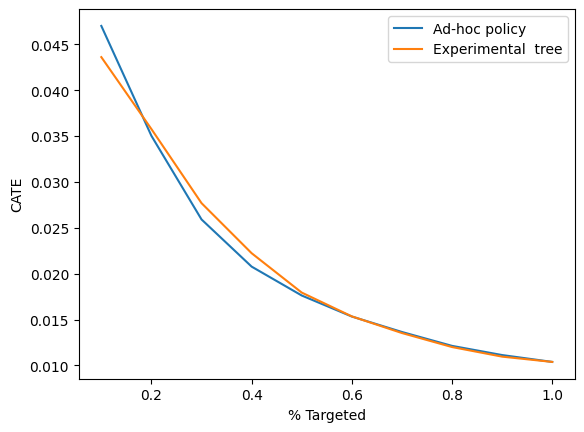

In [11]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
eval_df['pred'] = exp_tree.predict(eval_df[limited_features])
evaluate(eval_df, "Experimental  tree")
plt.show()

Train policy with observational data.

In [12]:
obs_tree = fit_causal_tree(obs_df, min_samples_leaf=exp_tree.min_samples_leaf)

--- Time to fit (and tune) causal tree 3.2540206909179688 seconds ---


Evaluate policy with observational data.

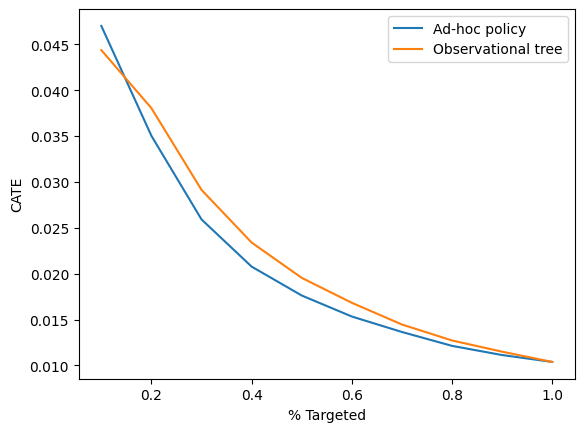

In [13]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
eval_df['pred'] = obs_tree.predict(eval_df[limited_features])
evaluate(eval_df, "Observational tree")
plt.show()

Merge both data sets.

In [14]:
obs_exp_df = pd.concat([obs_df, exp_df]).reset_index()      # duplicate indice due to an overlap between obs and exp data, so reindex them
obs_exp_df['experiment'] = False
obs_exp_df.loc[obs_exp_df.tail(exp_df.shape[0]).index, 'experiment'] = True
obs_exp_df = obs_exp_df.sample(frac=1).rename(columns={'treatment':'treated'})
X_dec = obs_exp_df[limited_features + ['treated', 'experiment']]
y_dec = obs_exp_df.visit

Fit deconfounder tree (legacy version).

In [15]:
start_time = time.time()
tuned_parameters = [{'min_weight_fraction_leaf': np.array(range(5, 55, 5))/100}]
#deconfounder = GridSearchCV(DeconfounderTree(random_state=42), tuned_parameters, cv=5)
deconfounder_legacy = DeconfounderTreeLegacy(random_state=42, min_weight_fraction_leaf=0.1)
deconfounder_legacy.fit(X_dec, y_dec)
print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
pd.Series(deconfounder_legacy.predict(X_dec)).value_counts()

--- Time to fit (and tune) causal tree 1.7836024761199951 seconds ---


 0.000815    116843
 0.007365    102306
 0.022080     85820
-0.002752     80453
-0.005862     78056
 0.162803     75038
 0.009356     72605
-0.006225     69710
dtype: int64

Evaluate with deconfounder tree (legacy version).

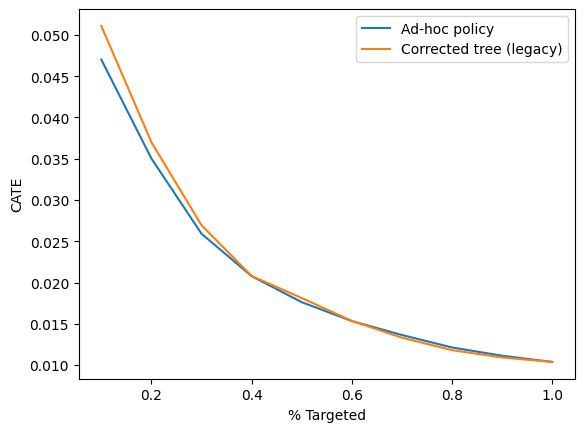

In [16]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
eval_df['pred'] = obs_tree.predict(eval_df[limited_features]) - deconfounder_legacy.predict(eval_df[limited_features]) 
evaluate(eval_df, "Corrected tree (legacy)")
plt.show()

Obtain X, y, and predicted treatment effects by the observational model for the experimental data

In [17]:
X_exp = exp_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y_exp = exp_df.visit.reset_index(drop=True)
eff_pred = obs_tree.predict(X_exp)

Fit deconfounder tree

In [18]:
start_time = time.time()
tuned_parameters = [{'min_weight_fraction_leaf': np.array(range(5, 55, 5))/100}]
#deconfounder = GridSearchCV(DeconfounderTree(random_state=42), tuned_parameters, cv=5)
deconfounder = DeconfounderTree(random_state=42, min_weight_fraction_leaf=0.1)
deconfounder.fit(X_exp, y_exp, eff_pred)
print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
pd.Series(deconfounder.predict(X_exp)).value_counts()

--- Time to fit (and tune) causal tree 35.109336137771606 seconds ---


-0.002153    7761
-0.001201    7484
 0.003860    6935
 0.007257    6101
 0.162788    5859
-0.003310    5600
 0.001307    5255
-0.001822    5005
dtype: int64

Evaluate with deconfounder tree

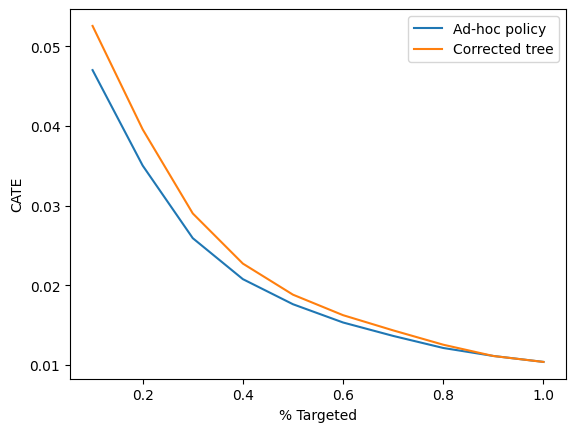

In [19]:
eval_df['pred'] = eval_df[confounder]
evaluate(eval_df, "Ad-hoc policy")
eval_df['pred'] = obs_tree.predict(eval_df[limited_features]) - deconfounder.predict(eval_df[limited_features]) 
evaluate(eval_df, "Corrected tree")
plt.show()

In [20]:
total_impressions = 1000000
boundary = 0.1
def get_avg_benefit(e_df):
    e_df = e_df.sort_values('pred', ascending=False)
    targeted = np.arange(e_df.shape[0]) / e_df.shape[0] < boundary 
    fraction = targeted.mean()
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    print(f"Marginal Visits: {np.round((avg_outcomes.loc[1] - avg_outcomes.loc[0])*total_impressions,0):,}")
    print(f"Estimated impact: {np.round(e_df[targeted].pred.mean() * total_impressions, 0):,}")

print("---Experimental---")
eval_df['pred'] = exp_tree.predict(eval_df[limited_features])
get_avg_benefit(eval_df)
print("---Observational---")
eval_df['obs_pred'] = obs_tree.predict(eval_df[limited_features])
eval_df['pred'] = eval_df['obs_pred']
get_avg_benefit(eval_df)
print("---Deconfounded (legacy)---")
eval_df['pred'] = eval_df['obs_pred'] - deconfounder_legacy.predict(eval_df[limited_features])
get_avg_benefit(eval_df)
print("---Deconfounded---")
eval_df['pred'] = eval_df['obs_pred'] - deconfounder.predict(eval_df[limited_features])
get_avg_benefit(eval_df)


---Experimental---
Marginal Visits: 43,606.0
Estimated impact: 59,092.0
---Observational---
Marginal Visits: 44,371.0
Estimated impact: 242,626.0
---Deconfounded (legacy)---
Marginal Visits: 51,088.0
Estimated impact: 122,273.0
---Deconfounded---
Marginal Visits: 52,553.0
Estimated impact: 210,432.0
